In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import time
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import random

load C:\Users\naufa\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\zlib1.dll...
load C:\Users\naufa\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\abseil_dll.dll...
load C:\Users\naufa\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\utf8_validity.dll...
load C:\Users\naufa\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\re2.dll...
load C:\Users\naufa\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\libprotobuf.dll...
load C:\Users\naufa\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\highs.dll...
load C:\Users\naufa\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\ortools.dll...


In [2]:
np.random.seed(42)
random.seed(42)

In [2]:
df_centroids = pd.read_csv("centroids_clusters_with_region.csv")
all_centroids = df_centroids[["X", "Y"]].values
coords_with_depot = np.vstack([[0, 0], all_centroids])

distance_matrix = cdist(coords_with_depot, coords_with_depot)

def solve_tsp_closed(coords):
    dist_mat = cdist(coords, coords).tolist()
    n = len(coords)
    depot = 0

    manager = pywrapcp.RoutingIndexManager(n, 1, depot)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_idx, to_idx):
        return int(dist_mat[manager.IndexToNode(from_idx)][manager.IndexToNode(to_idx)] * 1000)
    
    transit_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_index)

    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    search_params.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    search_params.time_limit.seconds = 186

    solution = routing.SolveWithParameters(search_params)

    if solution:
        index = routing.Start(0)
        route = []
        while not routing.IsEnd(index):
            route.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
        route.append(route[0])
        total_cost = sum(dist_mat[route[i]][route[i+1]] for i in range(len(route)-1))
        return route, total_cost
    else:
        return None, None

def fitness(tour, dist_matrix):
    return sum(dist_matrix[tour[i], tour[i+1]] for i in range(len(tour)-1)) + dist_matrix[tour[-1], tour[0]]

def generate_greedy_initial_route(dist_matrix):
    n = len(dist_matrix)
    unvisited = set(range(1, n))
    route = [0]
    current = 0
    while unvisited:
        next_node = min(unvisited, key=lambda x: dist_matrix[current][x])
        route.append(next_node)
        unvisited.remove(next_node)
        current = next_node
    return route

def two_opt(route, dist_matrix, max_iter=1000):
    best = route
    improved = True
    while improved and max_iter > 0:
        improved = False
        for i in range(1, len(route) - 2):
            for j in range(i+1, len(route) -1):
                if j - i == 1:
                    continue
                new_route = best[:i] + best[i:j][::-1] + best[j:]
                if fitness(new_route, dist_matrix) < fitness(best, dist_matrix):
                    best = new_route
                    improved = True
        max_iter -= 1
    return best

def get_neighbor(route):
    new_route = route[:]
    i, j = sorted(np.random.choice(range(1, len(route)), size=2, replace=False))
    move_type = np.random.choice(["reverse", "swap", "insert"])
    if move_type == "reverse":
        new_route[i:j+1] = reversed(new_route[i:j+1])
    elif move_type == "swap":
        new_route[i], new_route[j] = new_route[j], new_route[i]
    elif move_type == "insert":
        node = new_route.pop(i)
        new_route.insert(j, node)
    return new_route

def simulated_annealing(distance_matrix, initial_route,
    initial_temp=500, cooling_rate=0.99, stopping_temp=1e-4,
    max_iter=3000, interval_log=50, n_iter_2opt=10, local_max_iter=30,):
    current_route = initial_route[:]
    current_cost = fitness(current_route, distance_matrix)
    best_route = current_route[:]
    best_cost = current_cost
    temperature = initial_temp
    cost_log = []
    iteration = 0
    while temperature > stopping_temp and iteration < max_iter:
        neighbor_route = get_neighbor(current_route)
        if iteration % n_iter_2opt == 0:
            neighbor_route = two_opt(neighbor_route, distance_matrix, max_iter=local_max_iter)
        neighbor_cost = fitness(neighbor_route, distance_matrix)
        if neighbor_cost < current_cost or np.random.rand() < np.exp((current_cost - neighbor_cost) / temperature):
            current_route = neighbor_route
            current_cost = neighbor_cost
            if current_cost < best_cost:
                best_route = current_route[:]
                best_cost = current_cost
        cost_log.append(current_cost)
        if iteration % interval_log == 0:
            print(f"Iterasi {iteration:4d} | Cost: {current_cost:.2f} | Best: {best_cost:.2f} | Suhu: {temperature:.2f}")
        temperature *= cooling_rate
        iteration += 1
    print(f"Final Iterasi {iteration} | Best Cost: {best_cost:.2f}")
    return best_route, best_cost, cost_log

In [3]:
# === 5. Jalankan optimasi berkali-kali
num_runs = 10
all_best_costs = []
all_best_routes = []
all_durations = []

for run in range(num_runs):
    start_time = time.time()
    route, total_distance = solve_tsp_closed(coords_with_depot)
    duration = time.time() - start_time

    all_best_costs.append(total_distance)
    all_best_routes.append(route)
    all_durations.append(duration)

# === 6. Buat tabel hasil"
results_df = pd.DataFrame({
    "Run": [f"Run {i+1}" for i in range(num_runs)],
    "Best Cost": [f"{c:.2f}" if c else "None" for c in all_best_costs],
    "Durasi (detik)": [f"{t:.2f}" for t in all_durations]
})
from IPython.display import display
display(results_df)

,Run,Best Cost,Durasi (detik)
0,Run 1,1424.86,186.05
1,Run 2,1424.86,186.01
2,Run 3,1424.86,186.00
3,Run 4,1424.86,186.01
4,Run 5,1424.86,186.00
5,Run 6,1424.86,186.00
6,Run 7,1424.86,186.00
7,Run 8,1424.86,186.01
8,Run 9,1424.86,186.00
9,Run 10,1424.86,186.00


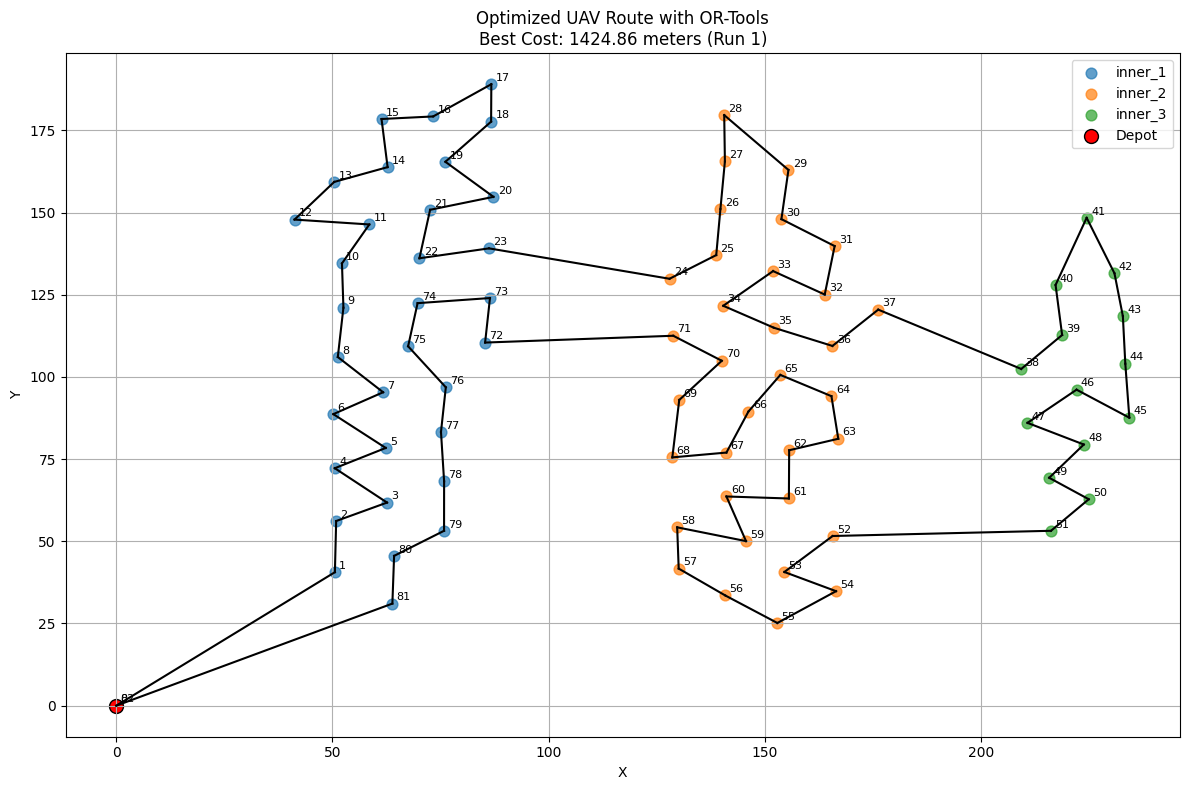

In [4]:
best_index = np.argmin(all_best_costs)
best_route = all_best_routes[best_index]
best_cost = all_best_costs[best_index]
def plot_route_with_region(coords, route, df_centroids, title=""):
    coords = np.array(coords)
    path = coords[route]

    # Buat DataFrame agar bisa pakai region
    df_coords = pd.DataFrame(coords, columns=["X", "Y"])
    df_coords["Region"] = "Depot"
    df_coords.loc[1:, "Region"] = df_centroids["Region"].values

    plt.figure(figsize=(12, 8))

    # Plot titik-titik centroid dengan warna berdasarkan Region
    for region in ["inner_1", "inner_2", "inner_3"]:
        region_points = df_coords[df_coords["Region"] == region]
        plt.scatter(region_points["X"], region_points["Y"], s=60, label=region, alpha=0.7)

    # Plot depot
    plt.scatter(df_coords.iloc[0]["X"], df_coords.iloc[0]["Y"], s=100, c='red', edgecolor='black', label="Depot")

    # Gambar jalur rute UAV
    for i in range(len(route) - 1):
        start = coords[route[i]]
        end = coords[route[i+1]]
        plt.plot([start[0], end[0]], [start[1], end[1]], 'k-', linewidth=1.5)

    # Tutup ke depot
    start = coords[route[-1]]
    end = coords[route[0]]
    plt.plot([start[0], end[0]], [start[1], end[1]], 'k-', linewidth=1.5)

    # Annotasi urutan titik
    for i, idx in enumerate(route):
        x, y = coords[idx]
        plt.annotate(str(i), (x + 1, y + 1), fontsize=8)

    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_route_with_region(coords_with_depot, best_route, df_centroids, 
    title=f"Optimized UAV Route with OR-Tools\nBest Cost: {best_cost:.2f} meters (Run {best_index+1})")

In [7]:
num_runs = 10
all_best_costs = []
all_best_routes = []
all_cost_logs = []
all_durations = []

for run in range(num_runs):
    initial_route = generate_greedy_initial_route(distance_matrix)
    start_time = time.time()
    best_route, best_cost, cost_log = simulated_annealing(distance_matrix, initial_route)
    duration = time.time() - start_time
    all_best_costs.append(best_cost)
    all_best_routes.append(best_route)
    all_cost_logs.append(cost_log)
    all_durations.append(duration)

# === 6. Buat dataframe hasil
results_df = pd.DataFrame({
    "Run": [f"Run {i+1}" for i in range(num_runs)],
    "Best Cost": [f"{c:.2f}" for c in all_best_costs],
    "Durasi (detik)": [f"{t:.2f}" for t in all_durations]
})
from IPython.display import display 
display(results_df)

Iterasi    0 | Cost: 1678.33 | Best: 1678.33 | Suhu: 500.00
Iterasi   50 | Cost: 1638.17 | Best: 1638.17 | Suhu: 302.50
Iterasi  100 | Cost: 1592.51 | Best: 1567.54 | Suhu: 183.02
Iterasi  150 | Cost: 1621.65 | Best: 1567.54 | Suhu: 110.73
Iterasi  200 | Cost: 1649.45 | Best: 1567.54 | Suhu: 66.99
Iterasi  250 | Cost: 1548.04 | Best: 1548.04 | Suhu: 40.53
Iterasi  300 | Cost: 1504.85 | Best: 1504.85 | Suhu: 24.52
Iterasi  350 | Cost: 1495.85 | Best: 1493.61 | Suhu: 14.84
Iterasi  400 | Cost: 1494.78 | Best: 1484.67 | Suhu: 8.98
Iterasi  450 | Cost: 1492.40 | Best: 1484.67 | Suhu: 5.43
Iterasi  500 | Cost: 1487.88 | Best: 1484.67 | Suhu: 3.29
Iterasi  550 | Cost: 1487.70 | Best: 1484.67 | Suhu: 1.99
Iterasi  600 | Cost: 1487.88 | Best: 1484.67 | Suhu: 1.20
Iterasi  650 | Cost: 1472.55 | Best: 1472.55 | Suhu: 0.73
Iterasi  700 | Cost: 1457.93 | Best: 1457.93 | Suhu: 0.44
Iterasi  750 | Cost: 1457.93 | Best: 1457.93 | Suhu: 0.27
Iterasi  800 | Cost: 1457.93 | Best: 1457.93 | Suhu: 0.16
It

,Run,Best Cost,Durasi (detik)
0,Run 1,1448.17,59.60
1,Run 2,1465.68,57.10
2,Run 3,1463.40,56.36
3,Run 4,1488.64,54.38
4,Run 5,1436.43,53.69
5,Run 6,1462.01,55.26
6,Run 7,1441.94,52.47
7,Run 8,1429.25,56.00
8,Run 9,1492.17,55.91
9,Run 10,1435.67,55.53


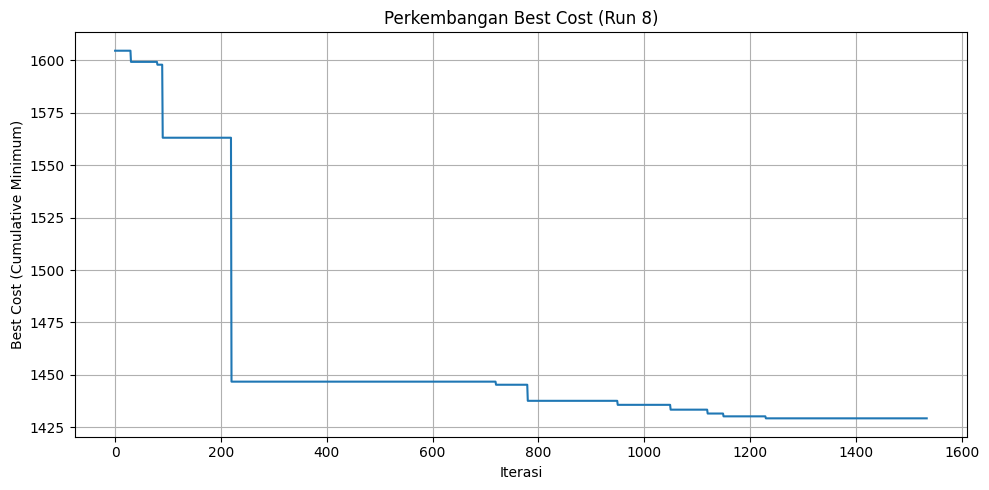

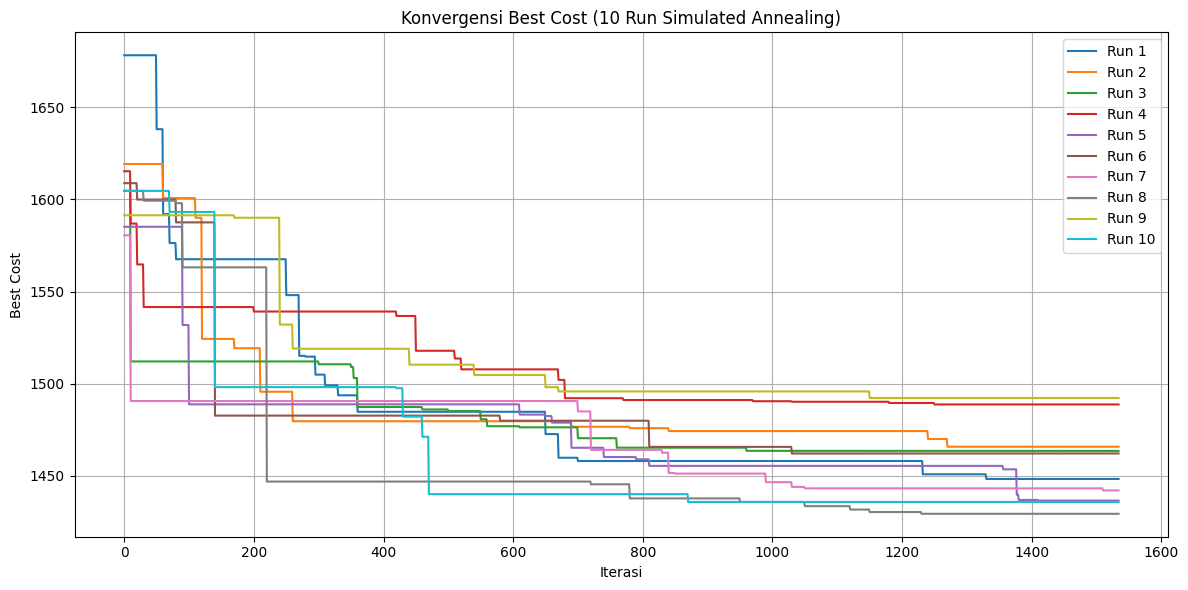

In [10]:
best_run_index = np.argmin(all_best_costs)
best_run_log = all_cost_logs[best_run_index]
best_cost_progress = np.minimum.accumulate(best_run_log)

plt.figure(figsize=(10, 5))
plt.plot(best_cost_progress)
plt.title(f"Perkembangan Best Cost (Run {best_run_index+1})")
plt.xlabel("Iterasi")
plt.ylabel("Best Cost (Cumulative Minimum)")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 9. Plot all run convergence
plt.figure(figsize=(12, 6))
for i, log in enumerate(all_cost_logs):
    progress = np.minimum.accumulate(log)
    plt.plot(progress, label=f"Run {i+1}")
plt.xlabel("Iterasi")
plt.ylabel("Best Cost")
plt.title("Konvergensi Best Cost (10 Run Simulated Annealing)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

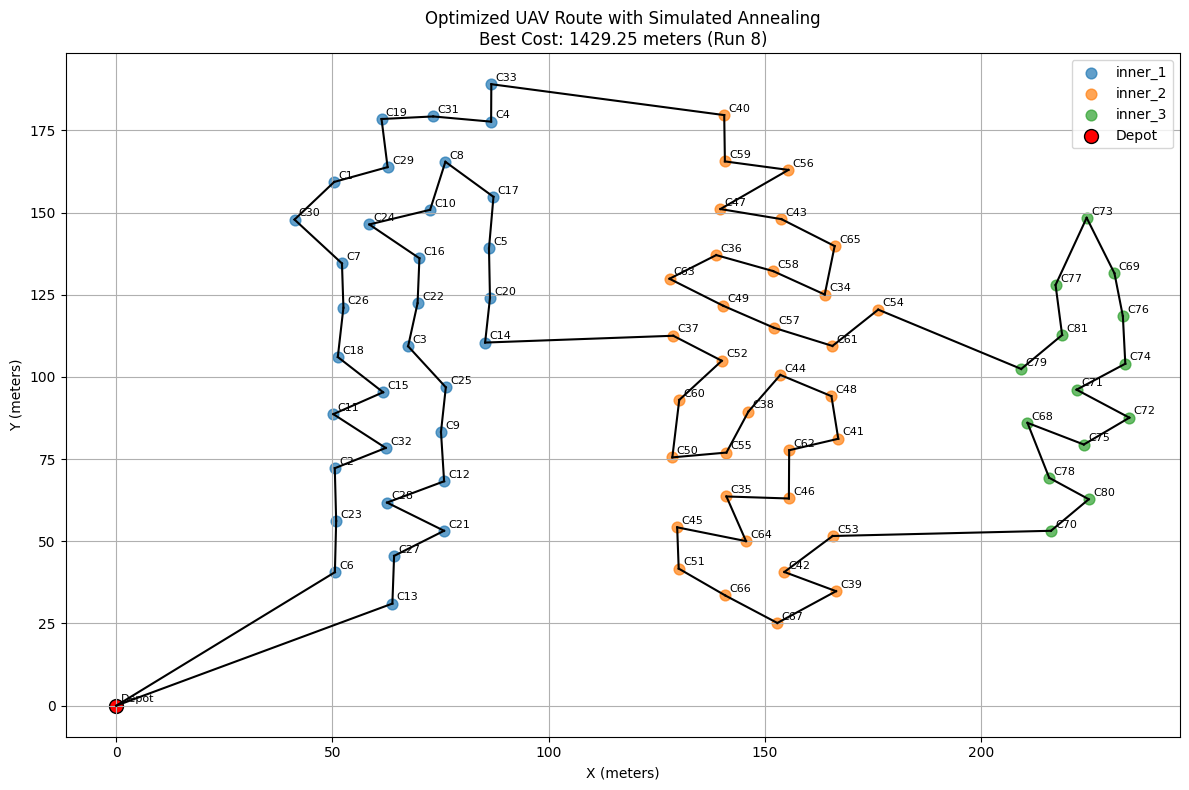

In [11]:
best_route = all_best_routes[best_run_index]
best_cost = all_best_costs[best_run_index]
plt.figure(figsize=(12, 8))

# DataFrame koordinat + region
df_coords = pd.DataFrame(coords_with_depot, columns=["X", "Y"])
df_coords["Region"] = "Depot"
df_coords.loc[1:, "Region"] = df_centroids["Region"].values  # centroid mulai index 1

# Scatter titik centroid per inner
for region in ["inner_1", "inner_2", "inner_3"]:
    region_points = df_coords[df_coords["Region"] == region]
    plt.scatter(region_points["X"], region_points["Y"], s=60, label=region, alpha=0.7)

# Scatter depot
plt.scatter(df_coords.iloc[0]["X"], df_coords.iloc[0]["Y"], s=100, c='red', edgecolor='black', label="Depot")

# Plot jalur rute UAV
for i in range(len(best_route) - 1):
    start = coords_with_depot[best_route[i]]
    end = coords_with_depot[best_route[i+1]]
    plt.plot([start[0], end[0]], [start[1], end[1]], 'k-', linewidth=1.5)
start = coords_with_depot[best_route[-1]]
end = coords_with_depot[best_route[0]]
plt.plot([start[0], end[0]], [start[1], end[1]], 'k-', linewidth=1.5)

# Label urutan traversal
for i, idx in enumerate(best_route):
    point = coords_with_depot[idx]
    label = "Depot" if idx == 0 else f"C{idx}"
    plt.annotate(label, (point[0] + 1, point[1] + 1), fontsize=8)

plt.title(f"Optimized UAV Route with Simulated Annealing\nBest Cost: {best_cost:.2f} meters (Run {best_run_index+1})")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
num_runs = 10
all_best_costs = []
all_best_routes = []
all_cost_logs = []
all_durations = []

for run in range(num_runs):
    np.random.seed(42 + run)
    random.seed(42 + run)
    initial_route = generate_greedy_initial_route(distance_matrix)
    start_time = time.time()
    best_route, best_cost, cost_log = simulated_annealing(distance_matrix, initial_route)
    duration = time.time() - start_time
    all_best_costs.append(best_cost)
    all_best_routes.append(best_route)
    all_cost_logs.append(cost_log)
    all_durations.append(duration)

# === 6. Buat dataframe hasil
results_df = pd.DataFrame({
    "Run": [f"Run {i+1}" for i in range(num_runs)],
    "Best Cost": [f"{c:.2f}" for c in all_best_costs],
    "Durasi (detik)": [f"{t:.2f}" for t in all_durations]
})
from IPython.display import display 
display(results_df)

Iterasi    0 | Cost: 1617.35 | Best: 1617.35 | Suhu: 500.00
Iterasi   50 | Cost: 1793.03 | Best: 1557.81 | Suhu: 302.50
Iterasi  100 | Cost: 1604.57 | Best: 1557.81 | Suhu: 183.02
Iterasi  150 | Cost: 1584.54 | Best: 1557.81 | Suhu: 110.73
Iterasi  200 | Cost: 1588.41 | Best: 1557.81 | Suhu: 66.99
Iterasi  250 | Cost: 1599.32 | Best: 1557.81 | Suhu: 40.53
Iterasi  300 | Cost: 1583.50 | Best: 1557.81 | Suhu: 24.52
Iterasi  350 | Cost: 1588.82 | Best: 1557.81 | Suhu: 14.84
Iterasi  400 | Cost: 1602.24 | Best: 1557.81 | Suhu: 8.98
Iterasi  450 | Cost: 1574.31 | Best: 1557.81 | Suhu: 5.43
Iterasi  500 | Cost: 1573.85 | Best: 1557.81 | Suhu: 3.29
Iterasi  550 | Cost: 1566.04 | Best: 1557.81 | Suhu: 1.99
Iterasi  600 | Cost: 1566.04 | Best: 1557.81 | Suhu: 1.20
Iterasi  650 | Cost: 1549.61 | Best: 1549.61 | Suhu: 0.73
Iterasi  700 | Cost: 1546.28 | Best: 1546.28 | Suhu: 0.44
Iterasi  750 | Cost: 1535.40 | Best: 1535.40 | Suhu: 0.27
Iterasi  800 | Cost: 1526.73 | Best: 1526.73 | Suhu: 0.16
It

KeyboardInterrupt: 

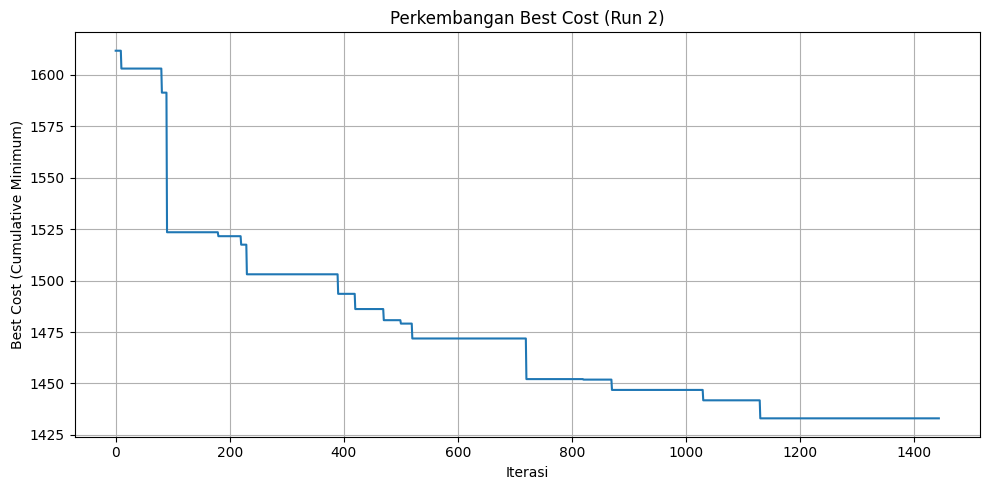

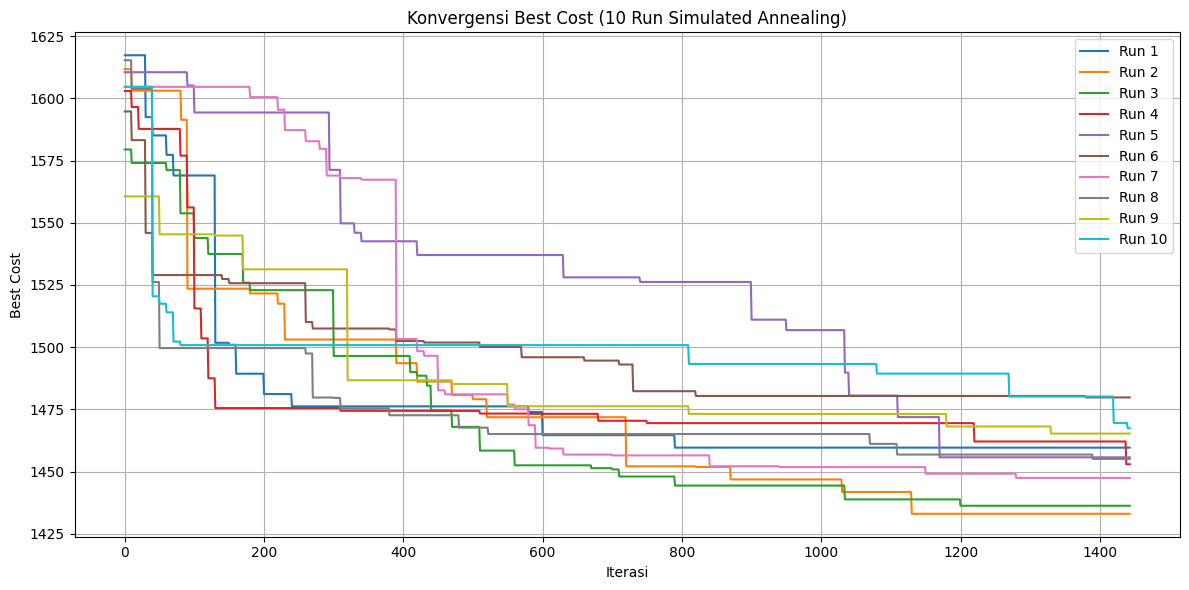

In [15]:
best_run_index = np.argmin(all_best_costs)
best_run_log = all_cost_logs[best_run_index]
best_cost_progress = np.minimum.accumulate(best_run_log)

plt.figure(figsize=(10, 5))
plt.plot(best_cost_progress)
plt.title(f"Perkembangan Best Cost (Run {best_run_index+1})")
plt.xlabel("Iterasi")
plt.ylabel("Best Cost (Cumulative Minimum)")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 9. Plot all run convergence
plt.figure(figsize=(12, 6))
for i, log in enumerate(all_cost_logs):
    progress = np.minimum.accumulate(log)
    plt.plot(progress, label=f"Run {i+1}")
plt.xlabel("Iterasi")
plt.ylabel("Best Cost")
plt.title("Konvergensi Best Cost (10 Run Simulated Annealing)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

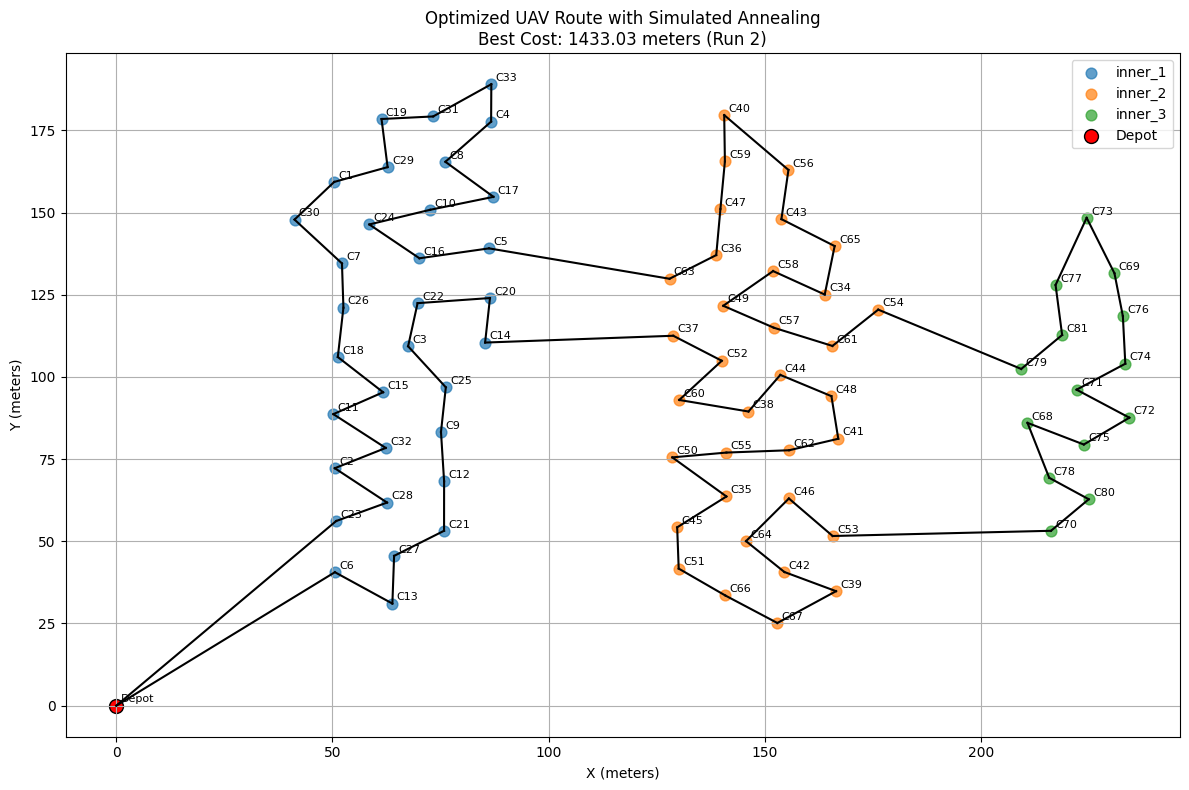

In [16]:
best_route = all_best_routes[best_run_index]
best_cost = all_best_costs[best_run_index]
plt.figure(figsize=(12, 8))

# DataFrame koordinat + region
df_coords = pd.DataFrame(coords_with_depot, columns=["X", "Y"])
df_coords["Region"] = "Depot"
df_coords.loc[1:, "Region"] = df_centroids["Region"].values  # centroid mulai index 1

# Scatter titik centroid per inner
for region in ["inner_1", "inner_2", "inner_3"]:
    region_points = df_coords[df_coords["Region"] == region]
    plt.scatter(region_points["X"], region_points["Y"], s=60, label=region, alpha=0.7)

# Scatter depot
plt.scatter(df_coords.iloc[0]["X"], df_coords.iloc[0]["Y"], s=100, c='red', edgecolor='black', label="Depot")

# Plot jalur rute UAV
for i in range(len(best_route) - 1):
    start = coords_with_depot[best_route[i]]
    end = coords_with_depot[best_route[i+1]]
    plt.plot([start[0], end[0]], [start[1], end[1]], 'k-', linewidth=1.5)
start = coords_with_depot[best_route[-1]]
end = coords_with_depot[best_route[0]]
plt.plot([start[0], end[0]], [start[1], end[1]], 'k-', linewidth=1.5)

# Label urutan traversal
for i, idx in enumerate(best_route):
    point = coords_with_depot[idx]
    label = "Depot" if idx == 0 else f"C{idx}"
    plt.annotate(label, (point[0] + 1, point[1] + 1), fontsize=8)

plt.title(f"Optimized UAV Route with Simulated Annealing\nBest Cost: {best_cost:.2f} meters (Run {best_run_index+1})")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
